# NOTE:
I recommend running this on a GPU, as it is much faster.

# Import Libraries

In [2]:
import os
import sys
import time
import functools
from textwrap import wrap

import numpy as np
import scipy.io
import scipy.misc

from PIL import Image

import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

# Build Model

Following the original [NST paper](https://arxiv.org/pdf/1508.06576.pdf), we will use the [VGG-19 Network](https://arxiv.org/pdf/1409.1556.pdf)

![VGG19 - Clifford K. Yang](img/vgg19.jpg)

The *Visual Geometry Group* (VGG) has published this pre-trained model, which gets its name from the 16 convolutional layers + 3 fully-connected layers. Its original purpose was image classification - it can detect 1,000 different objects in an image.

We are not interested in image classification, however, because this model was trained on over 1-million images from the [ImageNet](http://www.image-net.org/) database, it can effectively separate low-level features (at the earlier layers) from the high level features (at the deeper layers)



![arxiv - 1508.06576 - Figure 1](img/1508.06576.fig-1.png)

### Style Reconstructions:
A feature space is built on top of the filter responses for each layer in 

Recall that a digital image is a 3-dimensional vector (traditionally RGB, but defined as BGR in this model). The output of each layer also produces a BGR vector. We compare the correlations between each of these layers to define the style. An image can then be reconstructed based on the representations built on subsets of CNN layers:

**(a)**: conv1_1 

**(b)**: conv1_1 and conv2_1 

**(c)**: conv1_1, conv2_1 and conv3_1

**(d)**: conv1_1, conv2_1, conv3_1 and conv4_1 

**(e)**: conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1

### Content Reconstructions:
The lower layers (**a, b, c**) reproduce seemingly identical pixels of the input image, whereas the higher layers (**d, e**) capture the *content* of the image, but do not constrain the exact pixel values.
**(a)** - conv1_1, **(b)** - conv2_1 ,**(c)** - conv3_1, **(d)** - conv4_1, **(e)** - conv5_1

In [3]:
styleDict = {
    'a': ['conv1_1'],
    'b': ['conv1_1', 'conv2_1'],
    'c': ['conv1_1', 'conv2_1', 'conv3_1'],
    'd': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
    'e': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']   
}

contentLayer = 'conv4_2'

Tensorflow includes the vgg19 model under tf.keras.applications, however, the original NST paper made a few modifications. Namely, they do not use maxpooling, but instead use average pooling, which results in a better final image.

log0 has created a [function](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style) which modifies the vgg19 model to include average pooling. I have used his `load_vgg_model()` function, and made a modification that allows images of any size to be used. This function requires the pre-trained network as a .mat file, which can be downloaded [here](http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat). I did not include it in the repository because it is 500 MB.

In [4]:
from helperFunctions.log0.vgg_config import load_vgg_model
vgg = load_vgg_model('models/imagenet-vgg-verydeep-19.mat')

Instructions for updating:
Colocations handled automatically by placer.


# Cost Functions

### Content Loss
We want our generated image to have content which is similar to the content image. As such, we need to define a loss function so that the neural network knows how "close" it is to the original content image. 

Given a hidden layer (in this case, using block4_conv2), we take the sum of squared error - where the error is defined as the difference in activations between the content image and the generated image. Following the convention used in the original NST paper, we will define our loss as follows:


$$J_{content}(C,G) =  \frac{1}{4 \times height \times width \times channels}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2$$



In [5]:
def compute_content_cost(content_activations, generated_activations):    
    """
    purpose:
        For a **single layer's** activations, compute the cost between a generated
        image and the original content image
    
    details:
        - Following arXiv:1508.06576, compute the cost as defined in the equation above
    args:
        content_activations   (4D array)
            - numpy representation of content image's activations
            
        generated_activations (4D array)
            - numpy representation of generated image's activations
    
    rets:
        Sum of squared errors, multiplied by (1/4 * height * width * channels)
    """
    
    m, height, width, channels = generated_activations.get_shape().as_list()
    
    return 1 / (4 * height * width * channels) *  tf.reduce_sum(tf.square(content_activations - generated_activations))


### Style Loss - Gram Matrices
Recall that a [gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) is calculated by taking the dot product of a matrix transposed by itself. Andrew Ng has a helpful visualization in his coursera series on Convolutional Neural Networks:

![Andrew Ng - Gram Matrix](img/andrew_ng_gram.png)

In [6]:
def gram_matrix(A):
    """
    args:
        A: - matrix of shape (n_c, n_H*n_W)
    rets:
        Gram Matrix of A, shape (n_C, n_C)
    """
    return tf.matmul(A, tf.transpose(A))

The style cost function is essentially the same as the content cost function, with two changes:

1) The sum of squared error is now with regard to the two gram matrices

2) The channels, height, and width in the denominator are squared

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2$$

In [7]:
def compute_single_style_cost(style_activations, generated_activations):
    """
    purpose:
        For a **single** hidden layer's activations, compute the cost between a
        generated image and the original style image

    details:
        - 1) Create a gram matrix for both activations
        - 2) Compute the cost, as described above
        
    args:
        style_activations   (4D array)
            - numpy representation of content image's activations
            
        generated_activations (4D array)
            - numpy representation of generated image's activations
    
    rets:
        Sum of squared errors, multiplied by (1/4 * channels^2 * (height * width)^2 )
    """
    
    m, height, width, channels = generated_activations.get_shape().as_list()
    
    
    # reshape into 2 dimensional matrix, then transform into gram matrix
    style_activations = tf.transpose(tf.reshape(style_activations,
                                               (height*width, channels)))
    
    generated_activations = tf.transpose(tf.reshape(generated_activations,
                                                   (height*width, channels)))
    
    style_gram = gram_matrix(style_activations)
    generated_gram = gram_matrix(generated_activations)
    cost = 1 /(4*height*width*channels*height*width*channels)*(
        tf.reduce_sum(tf.square(tf.subtract(style_gram,generated_gram))))
        
   
    return cost
    

Since we do this for multiple layers, we will create another function that takes the average cost across all layers

In [8]:
def compute_avg_style_cost(model, style_layers):
    """
    purpose:
        Compute the average style cost for a given model, across given layers

    details:
        - Set coefficient to 1 / (n layers)
        - For each layer in style_layers, calculate the cost via
        compute_single_style_cost(). Take the average and return
        
    args:
        model - tensorflow model object
        style_layers - list - which layers to use for the style
    rets:
        todo
       
    """
    avg_cost = 0
    coeff = 1 / len(style_layers)
    for layer_name in style_layers:
        
        # filter to selected model
        out = model[layer_name]

        # create style activations and generated activations
        style_activation = sess.run(out)
        generated_activation = out

        # Compute individual cost for that layer
        individual_cost = compute_single_style_cost(style_activation, generated_activation)

        # multiply cost * coefficient, which gives us the average for all layers
        avg_cost += coeff * individual_cost

    return avg_cost


Now we weight and combine the two cost functions to give us our overall loss:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

Adjusting these weights will give us different outputs.

In [9]:
def compute_total_cost(content_loss, style_loss, alpha=10, beta=40):
    """
    purpose:
        Combine the content loss with the style loss, weighting accordingly
        
    args:
        content_loss - tensorflow object representing content loss
        style_loss   - tensorflow object representing style loss
        alpha        - integer weight to apply to content_loss
        beta         - integer weight to apply to style_loss
    rets:
        total_loss   - tensorflow object representing total loss
       
    """
    total_loss = alpha*content_loss + beta*style_loss
    return total_loss

# Preprocess Data

todo - consolidate functions, perhaps move into helperFunctions

If you've used Photoshop or similar software, you are probably used to the RGB convention of images. The [VGG Networks](https://arxiv.org/pdf/1409.1556.pdf) works with BGR instead. It also preprocesses the images by normalizing BGR through subtracting [103.939, 116.779, 123.68]. We will also need to add a 4th dimension.

However, as you know, matplotlib plots images with 3 dimensions in RGB, so we will also need to create a function that transforms these images back to normal.

In [10]:
def load_img(path_to_img, max_dim = 512):
    """
    purpose: 
        Reshape an input image into dimensions compatible with VGG19 model
    
    details:
        1) Load image
        2) Resize to maximum dimension size
        3) Store image in numpy array
        4) Convert 3D image into 4D via np.expand()
        
    args:
        path_to_img (string)    file location of image
        max_dim     (integer)   maximum dimensions for rescaling large images
        
    rets:
        img         (np array)  rescaled 4D image array
    """
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long

    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    return img        

In [11]:
def load_and_process_img(path_to_img):
    """
    purpose:
        apply vgg19 preprocessing to image
    args:
        path_to_img   (string)   file location of image
    rets:
        img           (np array) 4D representation of image
    """
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    """
    purpose:
        reverse vgg19 preprocessing
    details:
        -add [103.939, 116.779, 123.68] to respective BGR vectors
        -remove 4th dimension from image
    args:
        processed_img (4D np array)
    rets:
        img (3D np array)
    """
    img = processed_img.copy()
    if len(img.shape) == 4:
        img = np.squeeze(img, 0)
    else:
        raise ValueError("Invalid input to deprocessing image")

    img[:, :, 0] += 103.939 # Blue
    img[:, :, 1] += 116.779 # Green
    img[:, :, 2] += 123.68  # Red
    img = img[:, :, ::-1]   # 4D to 3D

    img = np.clip(img, 0, 255).astype('uint8')
    return img

We also need to ensure that the content image and the style image are of the same dimensions. This is because we need the dimensions in the hidden layers to be the same in order to calculate the cost functions that were defined above.

In [12]:
def reshape_images(content_image, style_image):
    _, w, h, _ = content_image.shape
    style_image = style_image[:,:w,:h,:] #reshape style
    
    _, w, h, _ = style_image.shape
    content_image = content_image[:,:w,:h,:] #reshape content
    return content_image, style_image

Since we are going to be generating many images, I've created a helper function to plot them along the specified axes.

In [13]:
def imshow(img, ax, title=None):
    """
    - todo - rename to avoid confusion
    purpose:
        -Remove 4th dimension from image array, plot via
        matplotlib.pyplot.imshow()
        
    args:
        img    (np array)    4D representation of image
        ax     (plt Axes)    Location of plotted image
        title  (string)      Title for plotted image
    """
    out = np.squeeze(img, axis=0).astype('uint8')
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.imshow(out)
    if title:
        ax.set_title(title)   

Recall that we are defining our cost function for both style and content by comparing to a generated image. We need a starting point for this image that is similar to the original content, but slightly different.

In order to accomplish that, we can add noise to our image.

In [14]:
def add_noise_to_image(image, ratio):
    """
    purpose:
        add ratio % noise to an image
    details:
        - create a random numpy array with same dimensions as input image
        - add (noise * ratio) + (image * 1-ratio)
    args:
        image (np array) original image
        ratio (float)    decimal representation of % noise to add
    rets:
        (np array) image with noise added
    
    """
    noise = np.random.uniform(-20, 20, (image.shape)).astype('float32')
    
    return (noise * ratio) + (image * (1 - ratio))

Here are some examples of what this noise looks like

todo - combine these two cells if it will stop freezing

In [15]:
noise_example = load_img('data/content/stonearch.jpg')
noise_pct = 0.0

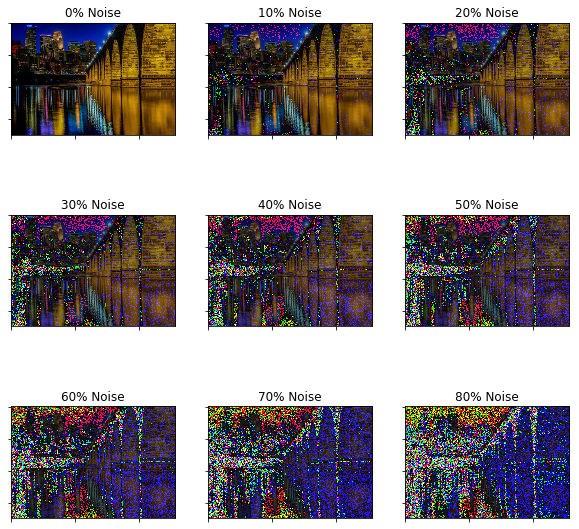

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(10,10))
for x in range(3):
    for y in range(3):
        noisy_img = add_noise_to_image(noise_example, noise_pct)
        imshow(noisy_img, ax[x][y], '{0:.0%} Noise'.format(noise_pct))
        noise_pct+= 0.1

Changing the percentage of noise in the original generated image can have drastic effects on the output. I demonstrate this later on, but the majority of examples I've created use 60% noise, as I've found that tends to have the most appealing results.


Now we can combine everything into a final function to generate our results.

In [18]:
def run_style_transfer(
             sess,
             content_path,
             style_path,
             model_path,
             name,
             contentLayer='conv4_2',
             styleLayers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'],
             noise_ratio=0.6,       
             num_iterations = 200):
    
    """
    purpose:
        -Apply neural style transfer from a style image onto a content image,
        in order to create a generated image
        
    details:
        1) Load an preprocess content image and style image according to vgg19 
        specifications
        
        2) Generate noisy image by using noise_ratio % of noise
        
        3) Load the vgg model provided by log0, and configure based on content image shape
        
        4) Combine weighted content cost & style cost, and then optimize via the
        AdamOptimizer in order to minimize this total cost. 
        
        5) Continue to minimize the total cost, updating values each iteration and
        re-calculating the loss.
        
        6) Each 20 iterations, store a snapshot of the image in output/
        
        7) Store the final image in output/
        
    args:
        sess -           tensorflow object - current tensorflow session
        content_path -   string -            file location of content image
        style_path -     string -            file location of style image
        model_path -     string -            file location of .mat model file
        name -           string -            name of output file
        contentLayer -   string -            which layer to use to define image content
        styleLayers -    list -              which **layers** to use to define style content
        noise_ratio -    float -             % of noise to use for initial generated image      
        num_iterations - integer -           number of epochs to use
    rets:
        generated_image- (4D np array) -      final generated image
        
    notes:
        The final image and all intermediate epoch images will be stored
        in data/generated/gatys/
    """    
    # Load images, resize, generate noisy image
    content_image = load_img(content_path).astype('uint8')
    style_image = load_img(style_path).astype('uint8')
    content_image, style_image = reshape_images(content_image, style_image)
    noisy_image = add_noise_to_image(content_image, ratio=noise_ratio)
    
    # load vgg model with specified dimensions, compute initial cost function
    vgg = load_vgg_model(model_path, content_image.shape)
    sess.run(vgg['input'].assign(content_image))

    content_activation = sess.run(vgg[contentLayer])
    generated_activation = vgg[contentLayer] # placeholder for now. will be updated later
    content_cost = compute_content_cost(content_activation, generated_activation)

    sess.run(vgg['input'].assign(style_image))
    style_cost = compute_avg_style_cost(vgg, styleLayers)

    total_cost = compute_total_cost(content_cost, style_cost,
                                    alpha=10, beta=40)

    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(total_cost)
    

    # initialize global variables, run the noisy image, loop through epochs
    sess.run(tf.global_variables_initializer())
    sess.run(vgg['input'].assign(noisy_image))

    for i in range(num_iterations):

        sess.run(train_step)
        generated_image = sess.run(vgg['input'])
       # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([total_cost, content_cost, style_cost])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))

            # save current generated image in the "/output" directory
            path = 'data/generated/gatys/{0}_{1}.png'.format(name, i)
            scipy.misc.imsave(path, deprocess_img(generated_image))

    # save last generated image
    path = 'data/generated/gatys/{0}_final.png'.format(name, i)
    scipy.misc.imsave(path, deprocess_img(generated_image))

    return generated_image

Note: This next cell will take quite a long time if it is not run on a GPU

In [ ]:
sess = tf.InteractiveSession()

# todo - remove model config above, since it needs to be re-defined on each image
run_style_transfer(sess,
         content_path='data/content/stonearch.jpg',
         style_path='data/style/rain_princess.jpg',
         model_path='models/imagenet-vgg-verydeep-19.mat',
         contentLayer='conv4_2',
         styleLayers=styleDict['e'],
         noise_ratio=0.6,       
         name='stonearch',
         num_iterations = 200)

# Results

Here is the original content image that has been transformed:
![Stonearch Bridge](data/content/stonearch.jpg)

This image was taken by Mac H (media601) on flickr, and this image has been labelled for re-use.

Each of these images were generated using `styleDict['e']`, with a noise percentage of 0.6.

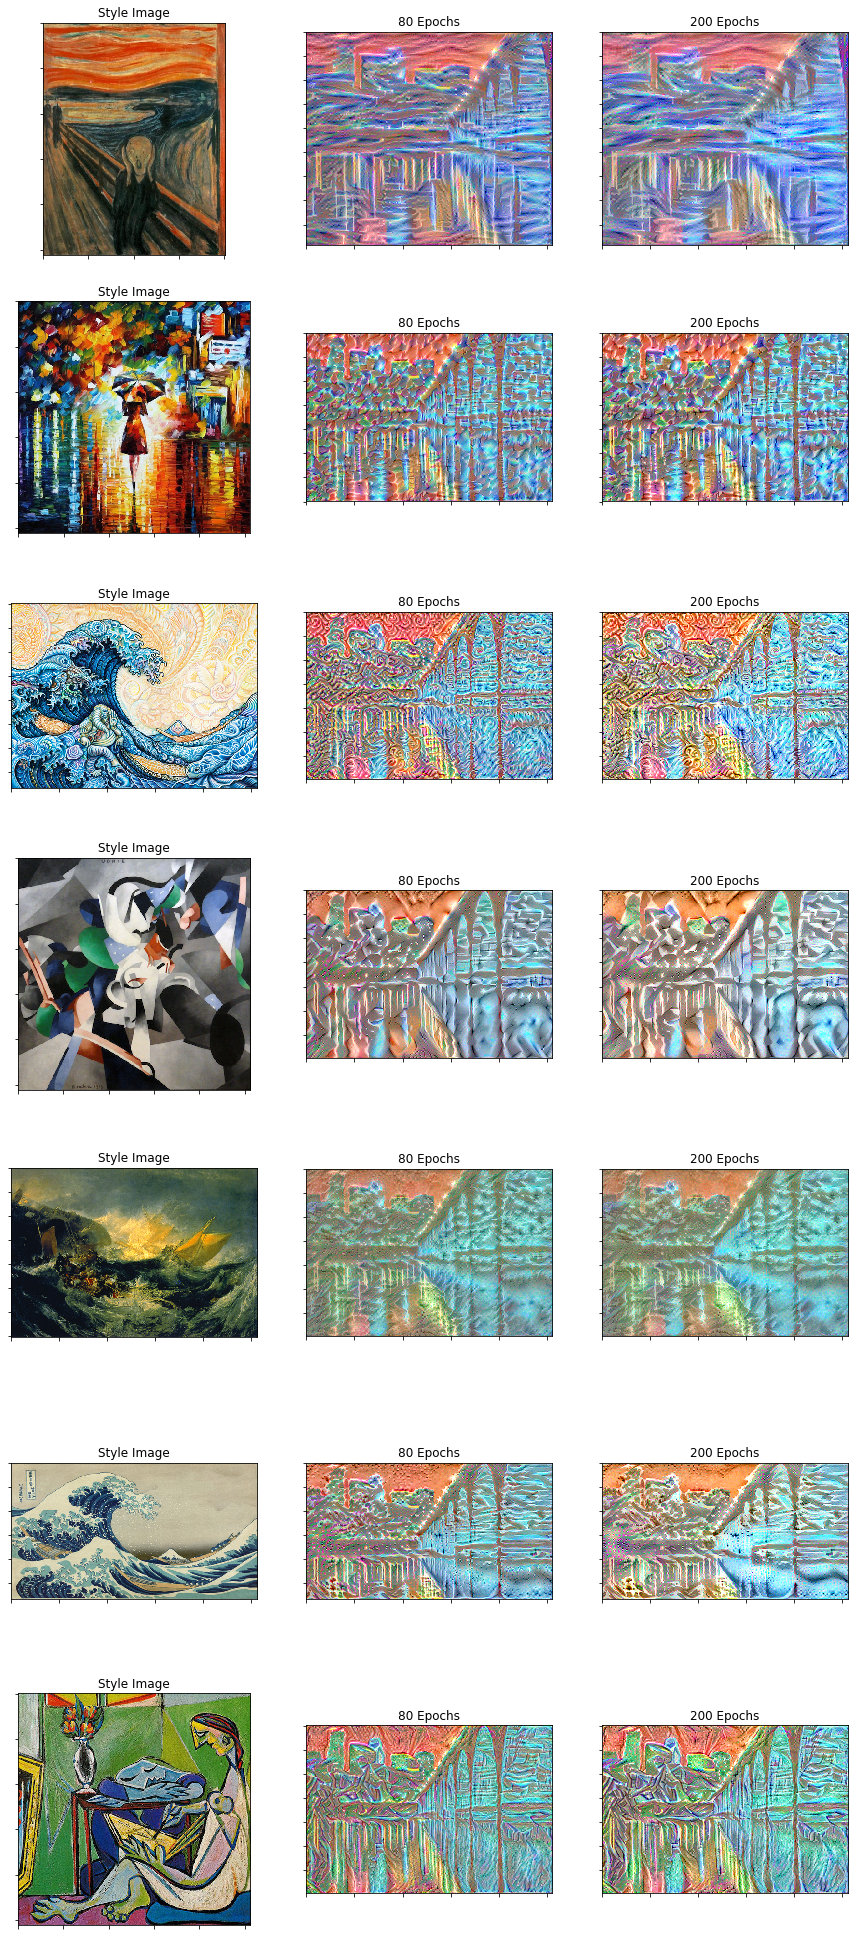

In [21]:
mpl.rcParams['figure.figsize'] = (30,30)
styleDir = 'data/style/'
generatedDir = 'data/generated/gatys/'
styleList = os.listdir(styleDir)

fig, ax = plt.subplots(len(styleList), 3, figsize=(15, 35))

x = 0
for fp in styleList:
    original = load_img(styleDir + fp)
    epoch_80 = load_img('{0}stonearch_{1}_80.png'.format(outputDir, fp[:-4]))
    final = load_img('{0}stonearch_{1}_final.png'.format(outputDir, fp[:-4]))
    
    imshow(original, ax[x][0], 'Style Image')
    imshow(epoch_80, ax[x][1], '80 Epochs')
    imshow(final, ax[x][2], '200 Epochs')
    
    x+=1
plt.show()

### Effects of noise
I generated the same style image, with an original noise percentage of 0.1, 0.3, 0.5, 0.7, and 0.9 values of noise.

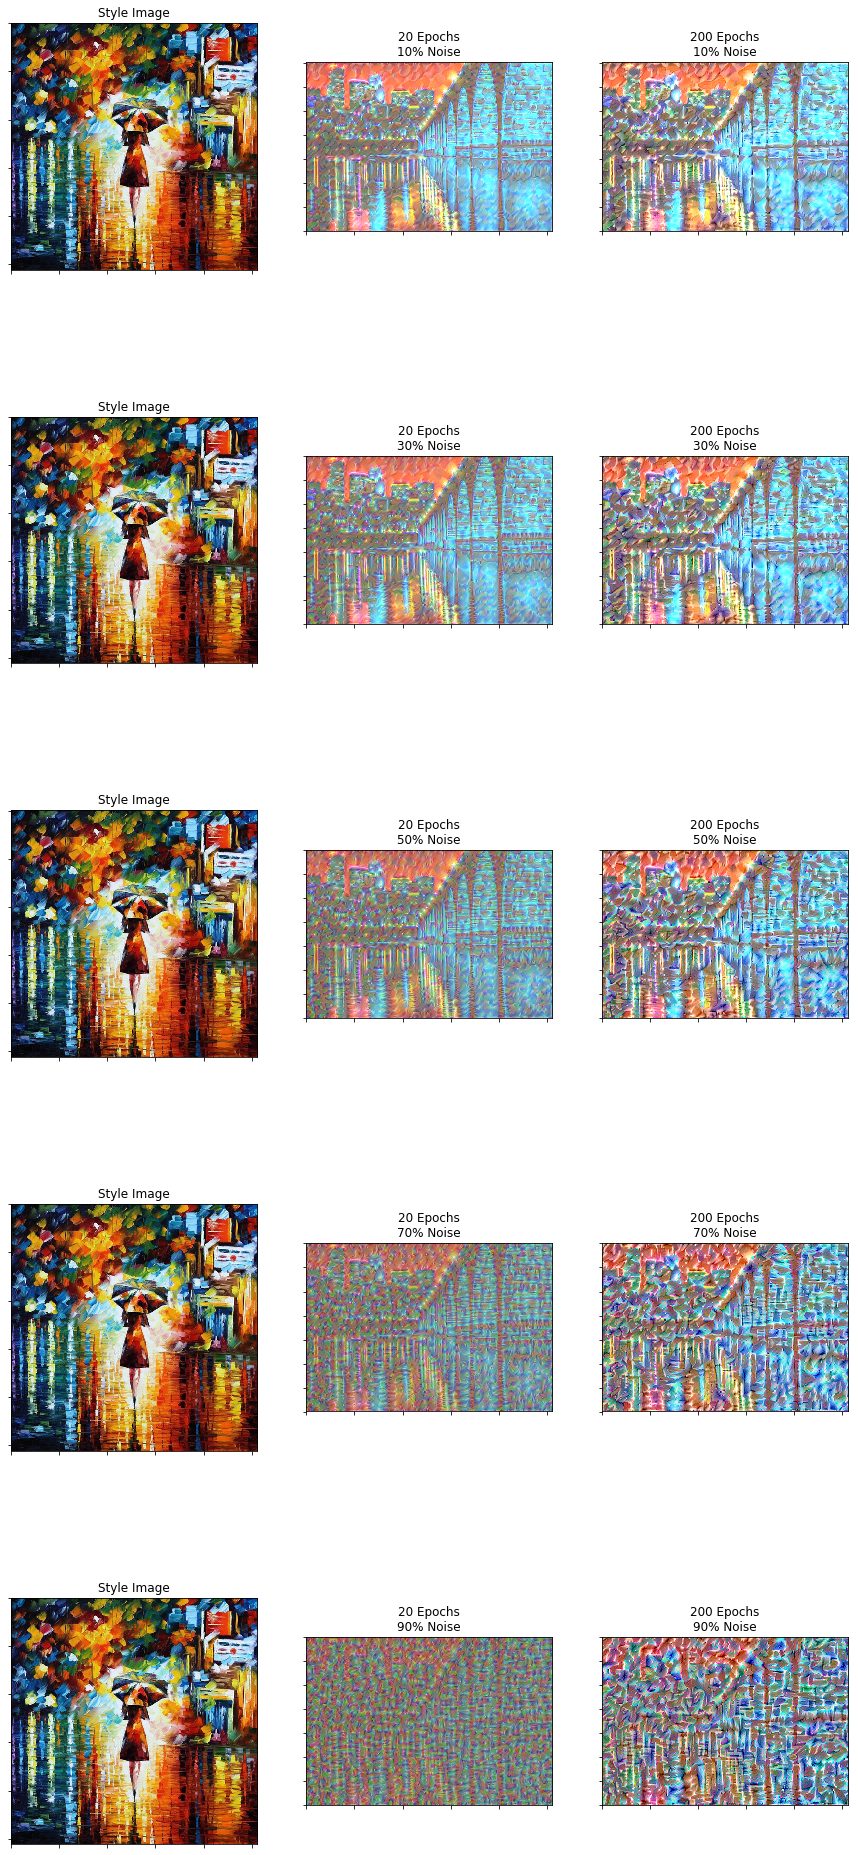

In [23]:
fig, ax = plt.subplots(5,3,figsize=(15,35))

original = load_img('data/style/rain_princess.jpg')
x = 0
for noise_pct in [0.1, 0.3, 0.5, 0.7, 0.9]:
    epoch_20 = load_img('data/generated/gatys/stonearch_rain_princess_{0}_noise_20.png'.format(noise_pct))
    final = load_img('data/generated/gatys/stonearch_rain_princess_{0}_noise_final.png'.format(noise_pct))
    
    imshow(original, ax[x][0], 'Style Image')
    imshow(epoch_20, ax[x][1], '20 Epochs\n{0:.0%} Noise'.format(noise_pct))
    imshow(final, ax[x][2], '200 Epochs\n{0:.0%} Noise'.format(noise_pct))
    
    x+=1
plt.show()

# Effects of Style Layers
Recall that the style cost is calculated by averaging the difference in activations at each layer. Also recall the various layers that were used in the original article:

In [24]:
styleDict

{'a': ['conv1_1'],
 'b': ['conv1_1', 'conv2_1'],
 'c': ['conv1_1', 'conv2_1', 'conv3_1'],
 'd': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
 'e': ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']}

I applied the style transfer using these various layers for style:

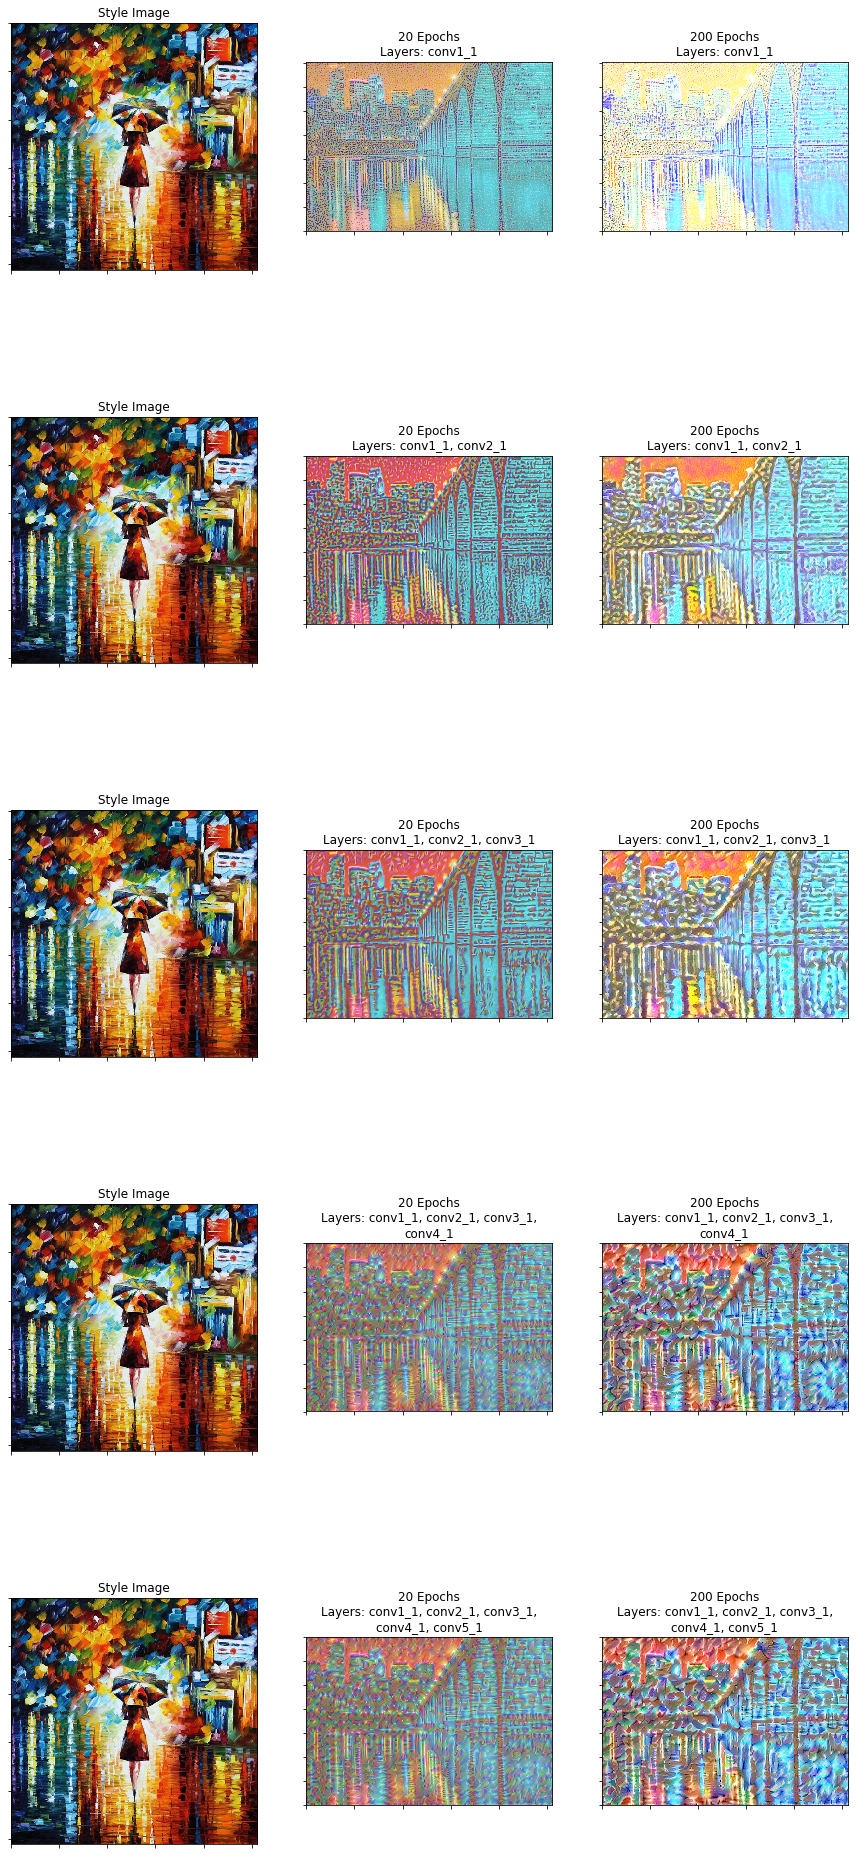

In [33]:
fig, ax = plt.subplots(5,3,figsize=(15,35))

original = load_img('data/style/rain_princess.jpg')
x = 0
for layers in styleDict.keys():
    subTitle = '\n'.join(wrap(', '.join(styleDict[layers]), width=30))
    
    epoch_20 = load_img('data/generated/gatys/stonearch_rain_princess_{0}_20.png'.format(layers))
    final = load_img('data/generated/gatys/stonearch_rain_princess_{0}_final.png'.format(layers))
    
    imshow(original, ax[x][0], 'Style Image')
    imshow(epoch_20, ax[x][1], '20 Epochs\nLayers: {0}'.format(subTitle))
    imshow(final, ax[x][2], '200 Epochs\nLayers: {0}'.format(subTitle))
    
    x+=1
plt.show()

# Fast Style Transfer

The method introduced by Gatys is somewhat slow, because inference requires solving an optimization problem for each image. An [alternate method](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) trains a network to understand the transformation between a style image and [~100,000 content images](https://arxiv.org/pdf/1405.0312.pdf). 


Once this network has been trained, it can transform a new content image in a single forward pass. Minimizing the same cost function as Gatys, a single forward pass in Johnson's method results in a score that is equivalent of 100-150 epochs from Gatys' method.


![JohnsonECCV16 - Figure 2](img\eccv16.fig-2.png)

This system consists of two components: an *image transformation network fw* and a *loss network φ* that is used to define several loss functions. The image transformation network (deep residual CNN) transforms input images into output images by mapping *y = fW (x)*. The image transformation network is trained using stochastic gradient descent to minimize a weighted combination of loss functions:
![JohnsonECCV16 - Section 3, Function 1](img\eccv16.func-3.1.png)

Image Transformation Architecture ([link](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf)):
![JohnsonECCV16Supplementary - Fig 1](img/eccv16-supplemental-fig-1.png)

A consequence of the downsampling > residual blocks > upsampling is that the content image becomes more generalized, and can capture larger concepts of an image instead of individual pixels:

![Source: https://cs.stanford.edu/people/jcjohns/eccv16/](img/eccv16.la-muse-comparison.png)

A major theme of *The Muse* is the presence of triangles. Johnson's method more effectively captures this theme, and also captures more of the texture. Gatys' method does still capture the style, but it appears to capture more *local* styles than *global* styles.

Because each style must be trained on ~100,000 content images, training can take quite a long time. 2 epochs take between 2-4 hours on an AWS p3.8xlarge server. Fortunately, [Logan Engstrom](https://github.com/lengstrom/fast-style-transfer) has pre-trained 6 models using this method (albeit with VGG19 instead of VGG16)

In [34]:
from helperFunctions.lengstrom import transform, vgg
from helperFunctions.lengstrom.utils import save_img, get_img, exists, list_files


In [38]:
def ffwd(content_path, model_path, name, device_t='/gpu:0'):
"""
    purpose:
        -Using a model that was trained via Johnson's method, transform a content
        image into a generated image with the respective style applied
        
    args:
        content_path -   string -            file location of content image
        model_path -     string -            file location of .ckpt model file
        name -           string -            name of output file
        device_t -       string -            device used to transform image

    rets:
        Nothing
        
    notes:
        The generated image will be stored in data/generated/gatys/
    """ 
    X = np.expand_dims(get_img(content_path), axis=0)
    output_path = 'data/generated/johnson/{0}.jpg'.format(name)
    
    g = tf.Graph()
    soft_config = tf.ConfigProto(allow_soft_placement=True)
    soft_config.gpu_options.allow_growth = True
    with g.as_default(), g.device(device_t), \
            tf.Session(config=soft_config) as sess:

        img_placeholder = tf.placeholder(tf.float32, shape=X.shape,
                                         name='img_placeholder')

        # load model, transform image
        preds = transform.net(img_placeholder)
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
        _preds = sess.run(preds, feed_dict={img_placeholder:X})
        
        # save
        save_img(output_path, _preds[0])

In [39]:
ffwd(content_path='data/content/stonearch.jpg',
     model_path='models/udnie.ckpt',
     name='stonearch_udnie')

INFO:tensorflow:Restoring parameters from models/udnie.ckpt


# Evaluate Differences

In [ ]:
mpl.rcParams['figure.figsize'] = (30,30)
styleDir = 'data/style/'
generatedDir = 'data/generated/gatys/'
styleList = os.listdir(styleDir)

fig, ax = plt.subplots(len(styleList), 3, figsize=(15, 35))

x = 0
for fp in styleList:
    original = load_img(styleDir + fp)
    epoch_80 = load_img('{0}stonearch_{1}_80.png'.format(outputDir, fp[:-4]))
    final = load_img('{0}stonearch_{1}_final.png'.format(outputDir, fp[:-4]))
    
    imshow(original, ax[x][0], 'Style Image')
    imshow(epoch_80, ax[x][1], '80 Epochs')
    imshow(final, ax[x][2], '200 Epochs')
    
    x+=1
plt.show()

# Sources:

### Content:
Stonearch Bridge - Mac H (media601) on flickr

### Style:
Rain Princess - Leonid Afremov

The Scream - Edvard Munch

The Shipwreck of the Minotaur - Joseph Mallord William Turner

Udnie - Francis Picabia

The Great Wave off Kanagawa - Hokusai

The Great Wave Remix - Randal Roberts


### Code:
[Neural Style Transfer - Raymond Yuan](https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398)

[Tensorflow Implementation Neural Algorithm of Artistic Style - Log0](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)

[Fast Style Transfer - Logan Engstrom](https://github.com/lengstrom/fast-style-transfer)

### Theory:
[A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf)

[Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)
